# 사전 작업

## 모듈 로드

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import gc

In [2]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold, StratifiedKFold

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
pd.set_option('display.max_columns', 400)

# 데이터 로드

In [5]:
path = './data/'

In [6]:
train = pd.read_csv(path + 'train_v3.csv')
test = pd.read_csv(path + 'test_v3.csv')

# 데이터 구분

In [7]:
train_neg = train[train.target < 0]
train_pos = train[train.target >= 0]
train_without_outliers = train[train.outliers == 0]

# 모델

## 제거할 피처

In [8]:
FEATS_EXCLUDED = ['first_active', 'card_id', 'target', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 
                  'new_purchase_date_max', 'new_purchase_date_min']

In [9]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

In [10]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [f for f in train.columns if f not in FEATS_EXCLUDED]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['outliers'].values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=train.iloc[trn_idx]['target'])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=train.iloc[val_idx]['target'])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
print("CV score: {:<8.5f}".format(mean_squared_error(train.target.values, oof_lgb)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.65093	valid_1's rmse: 3.71886
[200]	training's rmse: 3.56623	valid_1's rmse: 3.68747
[300]	training's rmse: 3.50999	valid_1's rmse: 3.67526
[400]	training's rmse: 3.4668	valid_1's rmse: 3.66859
[500]	training's rmse: 3.4312	valid_1's rmse: 3.66532
[600]	training's rmse: 3.40089	valid_1's rmse: 3.66367
[700]	training's rmse: 3.37362	valid_1's rmse: 3.66194
[800]	training's rmse: 3.35011	valid_1's rmse: 3.66162
[900]	training's rmse: 3.32715	valid_1's rmse: 3.66089
[1000]	training's rmse: 3.30606	valid_1's rmse: 3.66029
[1100]	training's rmse: 3.28622	valid_1's rmse: 3.65951
[1200]	training's rmse: 3.26596	valid_1's rmse: 3.65943
[1300]	training's rmse: 3.24718	valid_1's rmse: 3.6596
[1400]	training's rmse: 3.22819	valid_1's rmse: 3.65974
Early stopping, best iteration is:
[1248]	training's rmse: 3.25659	valid_1's rmse: 3.65928
fold n°1
Training until validation scores don't improve for 200 r

In [11]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

oof_lgb_neg = np.zeros(len(train_neg))
predictions_lgb_neg = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [f for f in train_neg.columns if f not in FEATS_EXCLUDED]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_neg, train_neg['outliers'].values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_neg.iloc[trn_idx][train_columns], label=train_neg.iloc[trn_idx]['target'])
    val_data = lgb.Dataset(train_neg.iloc[val_idx][train_columns], label=train_neg.iloc[val_idx]['target'])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb_neg[val_idx] = clf.predict(train_neg.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb_neg += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
print("CV score: {:<8.5f}".format(mean_squared_error(train_neg.target.values, oof_lgb_neg)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 4.37729	valid_1's rmse: 4.48336
[200]	training's rmse: 4.20132	valid_1's rmse: 4.41881
[300]	training's rmse: 4.09083	valid_1's rmse: 4.40427
[400]	training's rmse: 4.01414	valid_1's rmse: 4.39889
[500]	training's rmse: 3.95348	valid_1's rmse: 4.39641
[600]	training's rmse: 3.90102	valid_1's rmse: 4.39408
[700]	training's rmse: 3.85493	valid_1's rmse: 4.3923
[800]	training's rmse: 3.81237	valid_1's rmse: 4.39143
[900]	training's rmse: 3.77291	valid_1's rmse: 4.39225
Early stopping, best iteration is:
[793]	training's rmse: 3.81512	valid_1's rmse: 4.39137
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 4.37377	valid_1's rmse: 4.50167
[200]	training's rmse: 4.19686	valid_1's rmse: 4.42827
[300]	training's rmse: 4.08735	valid_1's rmse: 4.40599
[400]	training's rmse: 4.01152	valid_1's rmse: 4.39848
[500]	training's rmse: 3.95058	valid_1's rmse: 4.395

In [12]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

oof_lgb_pos = np.zeros(len(train_pos))
predictions_lgb_pos = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [f for f in train_pos.columns if f not in FEATS_EXCLUDED]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_pos, train_pos['outliers'].values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_pos.iloc[trn_idx][train_columns], label=train_pos.iloc[trn_idx]['target'])
    val_data = lgb.Dataset(train_pos.iloc[val_idx][train_columns], label=train_pos.iloc[val_idx]['target'])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb_pos[val_idx] = clf.predict(train_pos.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb_pos += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
print("CV score: {:<8.5f}".format(mean_squared_error(train_pos.target.values, oof_lgb_pos)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.09163	valid_1's rmse: 1.12028
[200]	training's rmse: 1.05349	valid_1's rmse: 1.0887
[300]	training's rmse: 1.03405	valid_1's rmse: 1.07696
[400]	training's rmse: 1.02055	valid_1's rmse: 1.07118
[500]	training's rmse: 1.00977	valid_1's rmse: 1.06757
[600]	training's rmse: 1.00037	valid_1's rmse: 1.06554
[700]	training's rmse: 0.991945	valid_1's rmse: 1.06445
[800]	training's rmse: 0.984353	valid_1's rmse: 1.06328
[900]	training's rmse: 0.977305	valid_1's rmse: 1.06244
[1000]	training's rmse: 0.970732	valid_1's rmse: 1.06198
[1100]	training's rmse: 0.964622	valid_1's rmse: 1.06162
[1200]	training's rmse: 0.958608	valid_1's rmse: 1.06127
[1300]	training's rmse: 0.9528	valid_1's rmse: 1.06094
[1400]	training's rmse: 0.947226	valid_1's rmse: 1.06065
[1500]	training's rmse: 0.941975	valid_1's rmse: 1.0606
[1600]	training's rmse: 0.936464	valid_1's rmse: 1.06038
[1700]	training's rmse: 0.931153	va

In [13]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

oof_lgb_without_outliers = np.zeros(len(train_without_outliers))
predictions_lgb_without_outliers = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [f for f in train_without_outliers.columns if f not in FEATS_EXCLUDED]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_without_outliers, train_without_outliers['outliers'].values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_without_outliers.iloc[trn_idx][train_columns], label=train_without_outliers.iloc[trn_idx]['target'])
    val_data = lgb.Dataset(train_without_outliers.iloc[val_idx][train_columns], label=train_without_outliers.iloc[val_idx]['target'])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb_without_outliers[val_idx] = clf.predict(train_without_outliers.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb_without_outliers += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
print("CV score: {:<8.5f}".format(mean_squared_error(train_without_outliers.target.values, oof_lgb_without_outliers)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.60508	valid_1's rmse: 1.61676
[200]	training's rmse: 1.57258	valid_1's rmse: 1.58947
[300]	training's rmse: 1.5569	valid_1's rmse: 1.57843
[400]	training's rmse: 1.54652	valid_1's rmse: 1.57278
[500]	training's rmse: 1.53831	valid_1's rmse: 1.56901
[600]	training's rmse: 1.53133	valid_1's rmse: 1.56669
[700]	training's rmse: 1.52511	valid_1's rmse: 1.56515
[800]	training's rmse: 1.51955	valid_1's rmse: 1.56427
[900]	training's rmse: 1.51443	valid_1's rmse: 1.5636
[1000]	training's rmse: 1.50958	valid_1's rmse: 1.56307
[1100]	training's rmse: 1.50494	valid_1's rmse: 1.56258
[1200]	training's rmse: 1.50054	valid_1's rmse: 1.56232
[1300]	training's rmse: 1.49619	valid_1's rmse: 1.56206
[1400]	training's rmse: 1.492	valid_1's rmse: 1.5618
[1500]	training's rmse: 1.4879	valid_1's rmse: 1.56166
[1600]	training's rmse: 1.48388	valid_1's rmse: 1.56144
[1700]	training's rmse: 1.47992	valid_1's rmse:

In [14]:
t1 = pd.DataFrame({"normal":predictions_lgb, "neg":predictions_lgb_neg, "pos":predictions_lgb_pos, "outlier":predictions_lgb_without_outliers})

In [15]:
t1['new'] = (t1.neg + t1.pos) / 2

In [16]:
t1.describe()

,normal,neg,pos,outlier,new
count,123623.000000,123623.000000,123623.000000,123623.000000,123623.000000
mean,-0.394675,-1.913839,1.036633,-0.029702,-0.438603
std,1.185794,1.831866,0.577003,0.712724,0.855673
min,-21.561490,-28.058831,-0.096679,-4.386942,-13.277049
25%,-0.646938,-1.984022,0.619404,-0.452410,-0.441549
50%,-0.211090,-1.388727,0.851169,-0.071796,-0.217155
75%,0.166128,-1.033168,1.295027,0.361093,-0.100269
max,3.204042,-0.371032,6.514404,4.793803,1.819758


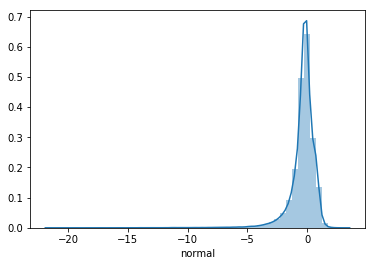

In [132]:
sns.distplot(t1.normal)

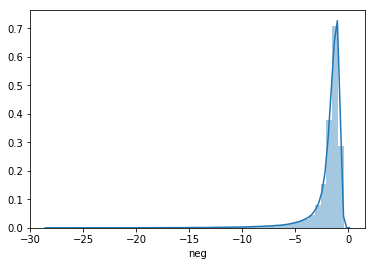

In [133]:
sns.distplot(t1.neg)

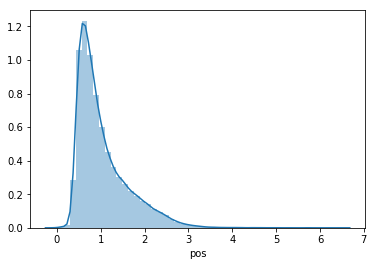

In [134]:
sns.distplot(t1.pos)

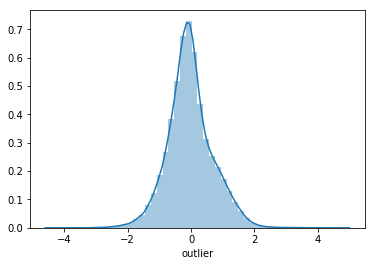

In [135]:
sns.distplot(t1.outlier)

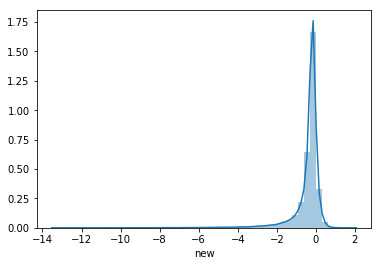

In [136]:
sns.distplot(t1.new)

# 이상치 예측 모델

In [206]:
target = train['outliers']

## 제거할 피처

In [207]:
FEATS_EXCLUDED = ['first_active', 'card_id', 'target', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 
                  'new_purchase_date_max', 'new_purchase_date_min']

## 파라미터

In [208]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "rf",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'binary_logloss',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 2333}

In [209]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

oof_lgb_log = np.zeros(len(train))
predictions_lgb_log = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [f for f in train.columns if f not in FEATS_EXCLUDED]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['outliers'].values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb_log[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb_log += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
print("CV score: {:<8.5f}".format(log_loss(target.values, oof_lgb_log)))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0439393	valid_1's binary_logloss: 0.0466941
[200]	training's binary_logloss: 0.0439582	valid_1's binary_logloss: 0.0466935
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.0439586	valid_1's binary_logloss: 0.0465615
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0439916	valid_1's binary_logloss: 0.0471326
[200]	training's binary_logloss: 0.044006	valid_1's binary_logloss: 0.0471322
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.0439602	valid_1's binary_logloss: 0.0470829
fold n°2
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0444197	valid_1's binary_logloss: 0.046345
[200]	training's binary_logloss: 0.0443985	valid_1's binary_logloss: 0.046319
[300]	training's binary_logloss: 0.0443899	valid_1's binary_logloss: 0.0462997
[400]	tra

In [248]:
outlier_prob = pd.DataFrame({"card_id":test["card_id"].values})
outlier_prob["target"] = predictions_lgb_log

# Combining

In [251]:
model_without_outliers = pd.DataFrame({"card_id":test["card_id"].values})
model_without_outliers["target"] = predictions_lgb_without_outliers

In [261]:
outlier_id = pd.DataFrame(outlier_prob.sort_values(by='target',ascending = False).head(400)['card_id'])

In [225]:
t1 = pd.DataFrame({'card_id':test.card_id, 'normal': predictions_lgb,'pos':predictions_lgb_pos, 'neg':predictions_lgb_neg, 'ouliers':predictions_lgb_without_outliers})

In [160]:
t1 = t1.set_index(test.card_id.values)

In [161]:
t1 = t1.reset_index()

In [162]:
t1.columns = ['card_id', 'normal', 'neg', 'pos', 'outlier', 'new']

In [167]:
for v in outlier_id.card_id:
    print(t1[t1.card_id == v][['normal', 'neg', 'pos', 'outlier', 'new']])

          normal        neg       pos  outlier        new
32446 -19.551338 -25.015652  1.433756 -0.18222 -11.790948
          normal        neg       pos   outlier       new
22650 -13.454734 -12.853212  0.743834 -1.122873 -6.054689
          normal        neg       pos   outlier        new
67665 -17.380549 -23.399879  1.980673  0.506923 -10.709603
           normal        neg       pos   outlier       new
105394 -14.014343 -13.819111  0.881716 -0.937218 -6.468698
          normal        neg       pos   outlier       new
33610 -14.763466 -16.116402  0.834797 -0.747194 -7.640803
          normal        neg       pos   outlier     new
41138 -15.419618 -20.974463  1.686063  0.027103 -9.6442
         normal        neg       pos   outlier      new
23336 -15.11739 -16.043246  1.239305 -1.048192 -7.40197
           normal        neg       pos   outlier       new
109705 -14.067543 -16.777381  0.881053 -1.023589 -7.948164
          normal        neg       pos   outlier       new
24677 -14.584636

           normal        neg      pos   outlier       new
107752 -14.375095 -16.567882  0.64258 -1.203142 -7.962651
          normal        neg       pos   outlier       new
63477 -12.122657 -22.835023  1.954744  1.088635 -10.44014
          normal        neg       pos  outlier       new
117101 -10.61213 -17.405485  1.349071  0.74986 -8.028207
          normal        neg       pos   outlier      new
63189 -13.531019 -18.444299  0.991719 -0.426175 -8.72629
          normal        neg       pos  outlier      new
22430 -11.753752 -16.878647  1.555627  0.32368 -7.66151
         normal       neg       pos   outlier       new
51752 -9.110929 -20.43943  2.378198  1.491076 -9.030616
          normal      neg       pos   outlier       new
23168 -14.402786 -18.8431  0.982873 -0.579784 -8.930114
          normal        neg       pos   outlier       new
23022 -11.591874 -16.045951  0.757435 -0.819013 -7.644258
           normal        neg       pos   outlier        new
108111 -16.586536 -24.255934

          normal        neg       pos   outlier        new
76303 -14.746477 -23.579936  1.703331  0.522765 -10.938303
         normal       neg       pos   outlier       new
61930 -9.819118 -13.56434  0.672712 -0.548388 -6.445814
         normal        neg       pos   outlier       new
59438 -10.07932 -17.507452  2.172384  1.064217 -7.667534
           normal        neg       pos   outlier       new
108678 -12.401197 -19.391207  2.106996  0.763365 -8.642106
         normal        neg       pos   outlier       new
80980 -7.697289 -11.913264  1.304167  0.107133 -5.304548
          normal        neg       pos   outlier       new
94668 -12.927277 -18.981574  1.344536 -0.034377 -8.818519
         normal        neg       pos   outlier       new
59340 -9.777366 -18.210949  1.646959  0.765643 -8.281995
         normal        neg       pos   outlier       new
97925 -8.515063 -20.068535  1.951646  1.095857 -9.058444
        normal        neg       pos   outlier       new
13324 -7.44704 -11.64682

In [253]:
for card_id in outlier_id.card_id:
    model_without_outliers.loc[model_without_outliers['card_id'] == card_id, 'target'] = t1.loc[t1['card_id'] == card_id, 'normal']

In [262]:
for card_id in outlier_id.card_id:
    model_without_outliers.loc[model_without_outliers['card_id'] == card_id, 'target'] = (t1.loc[t1['card_id'] == card_id, 'normal'] + t1.loc[t1['card_id'] == card_id, 'neg']) / 2

In [263]:
model_without_outliers.to_csv("./data/submission_combining_neg_400.csv", index=False)

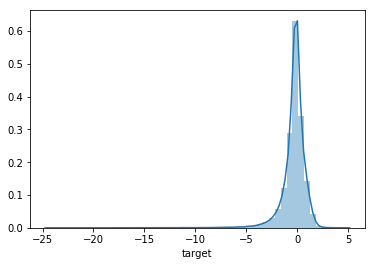

In [171]:
sns.distplot(model_without_outliers.target)

In [17]:
t2 = pd.DataFrame({"card_id":train.card_id,"target":train.target})

In [18]:
t2 = t2.merge(pd.DataFrame({"card_id":train.card_id, "normal":oof_lgb}), how='left')
t2 = t2.merge(pd.DataFrame({"card_id":train_neg.card_id, "neg":oof_lgb_neg}), how='left')
t2 = t2.merge(pd.DataFrame({"card_id":train_pos.card_id, "pos":oof_lgb_pos}), how="left")
t2 = t2.merge(pd.DataFrame({"card_id":train_without_outliers.card_id, "outliers":oof_lgb_without_outliers}), how='left')

In [19]:
pd.set_option('display.max_rows', 400)

In [105]:
(t2[np.abs(t2.target) < 5].shape[0] / t2.shape[0]) * 100

97.12208481702878

In [107]:
120000 * 0.015

1800.0

In [99]:
def get_target(data):
    temp = 5
    if data.normal < -1 * temp:
        return data.neg
    elif data.normal > 1 * temp:
        return data.pos
    else:
        if data.outliers == np.nan:
            return data.normal
        else:
            return data.outliers

In [100]:
t2['combi'] = t2.sort_values('target').apply(get_target, axis=1)

In [142]:
small = t2[['card_id', 'neg']].sort_values('neg')[:100]

In [125]:
big = t2[['card_id', 'pos']].sort_values('pos', ascending=False)[:2200]

In [140]:
targett = t2[['card_id', 'outliers']]

In [143]:
for card_id in small.card_id:
    targett.loc[targett['card_id'] == card_id, 'outliers'] = small.loc[small['card_id'] == card_id, 'neg']

In [ ]:
for card_id in big.card_id:
    targett.loc[targett['card_id'] == card_id, 'outliers'] = big.loc[big['card_id'] == card_id, 'pos']

In [114]:
targett = t2.outliers

In [115]:
targett

0        -0.284566
1         0.218978
2         0.595680
3         0.197117
4        -0.128851
5        -0.468703
6        -0.326014
7        -0.065392
8         0.279655
9         0.108912
10       -0.670848
11        0.709638
12        0.616103
13       -0.791130
14       -0.461175
15        0.851880
16       -0.176523
17        0.094076
18        0.188481
19       -1.163620
20       -0.101604
21        0.776912
22       -0.029068
23       -0.524358
24       -0.084263
25        0.775441
26       -0.337966
27        1.005681
28       -0.350599
29       -0.479195
30       -0.259007
31       -0.130568
32       -0.134131
33        0.535539
34       -0.632174
35       -0.788365
36       -0.188971
37       -0.633217
38       -1.380829
39       -0.050009
40       -0.128149
41       -0.478145
42       -0.771198
43        0.645870
44       -0.687717
45       -0.276898
46       -0.586976
47        1.071256
48       -0.072103
49        0.561598
50        0.017349
51        1.289210
52        0.

ValueError: cannot convert float NaN to integer

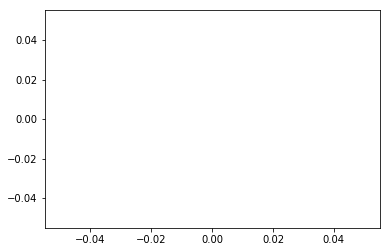

In [102]:
sns.distplot(t2.combi)

In [74]:
print("CV score: {:<8.5f}".format(mean_squared_error(train.target.values, t2.combi.values)**0.5))

CV score: 3.17599 


In [82]:
def get_target(data):
    temp = 5
    if data.target < -1 * temp:
        return data.neg
    elif data.target > 1 * temp:
        return data.pos
    else:
        return data.outlier

In [111]:
t1

,normal,neg,pos,outlier
0,-2.720133,-4.331296,0.704661,-0.572176
1,-0.324698,-1.284071,0.663272,-0.206976
2,-1.032917,-2.166165,0.929720,-0.343198
3,-0.158354,-0.798973,0.626297,-0.153566
4,-1.517383,-1.938962,0.443871,-1.342292
5,0.076411,-1.545281,0.992987,0.824028
6,0.000751,-0.804643,0.667343,0.138920
7,0.415883,-2.476315,2.118256,0.865891
8,-0.746597,-1.245295,0.803044,-0.722229
9,-0.811070,-2.267055,0.698531,-0.209246


In [110]:
for v in t1.values:
    print(v)
    break

[-2.72013254 -4.33129632  0.7046614  -0.57217602]


In [83]:
t1['combi'] = t1.apply(get_target, axis=1)

AttributeError: ("'Series' object has no attribute 'target'", 'occurred at index 0')

In [21]:
import matplotlib.pyplot as plt

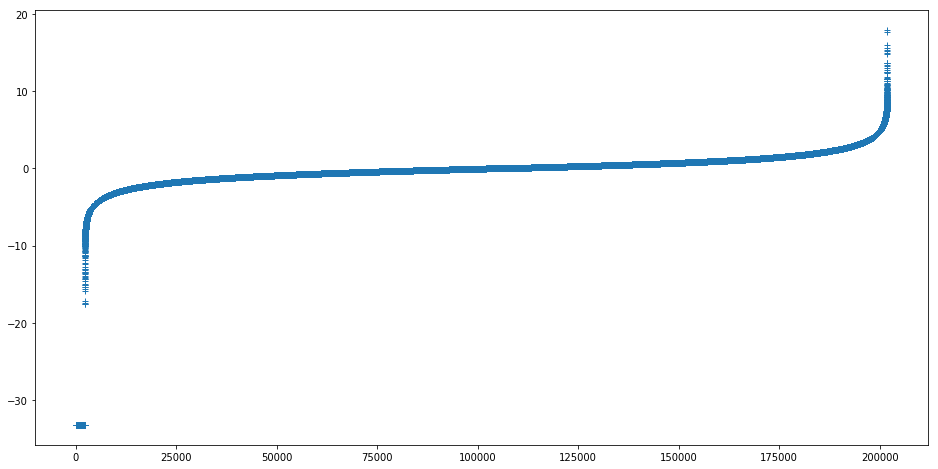

In [153]:
f, ax = plt.subplots(figsize=(16, 8))
plt.plot(t2.sort_values('target').target.values, '+', linewidth=0.0001)

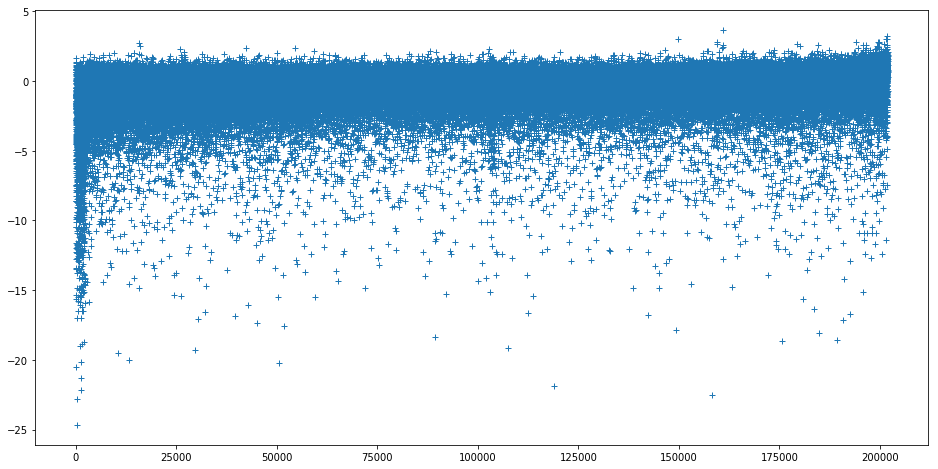

In [154]:
f, ax = plt.subplots(figsize=(16, 8))
plt.plot(t2.sort_values('target').normal.values, '+', linewidth=0.0001)

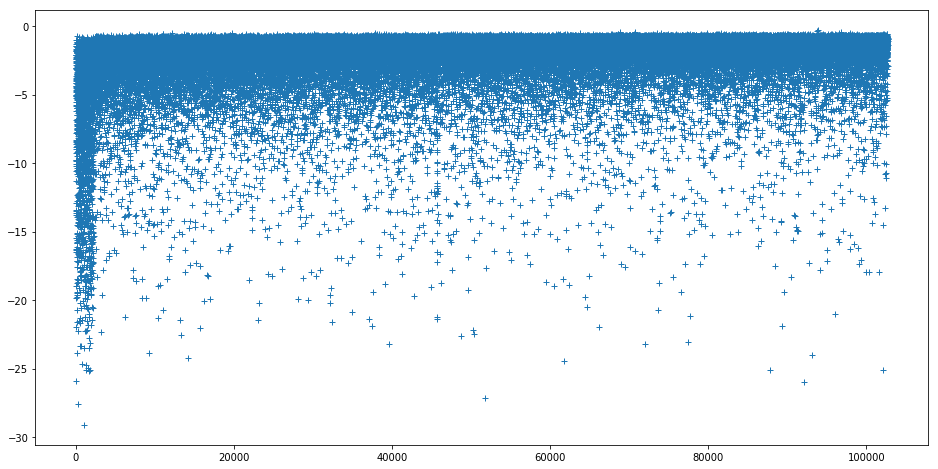

In [155]:
f, ax = plt.subplots(figsize=(16, 8))
plt.plot(t2.sort_values('target').neg.values, '+', linewidth=0.0001)

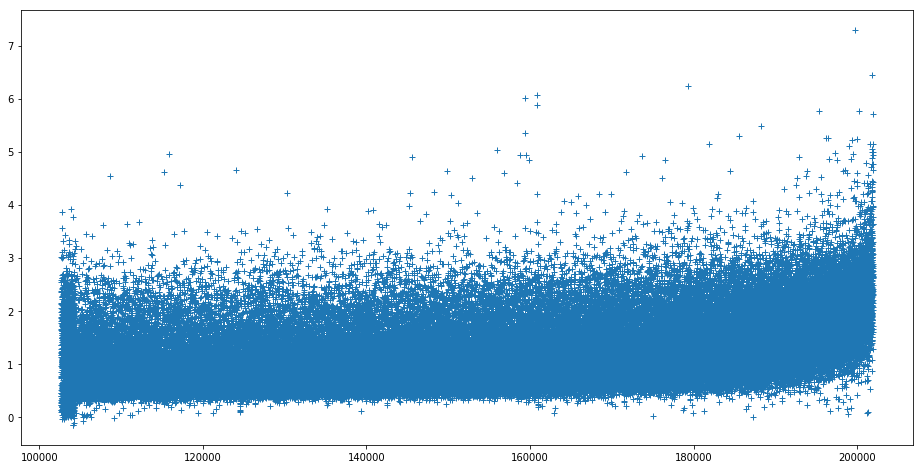

In [204]:
f, ax = plt.subplots(figsize=(16, 8))
plt.plot(t2.sort_values('target').pos.values, '+', linewidth=0.0001)

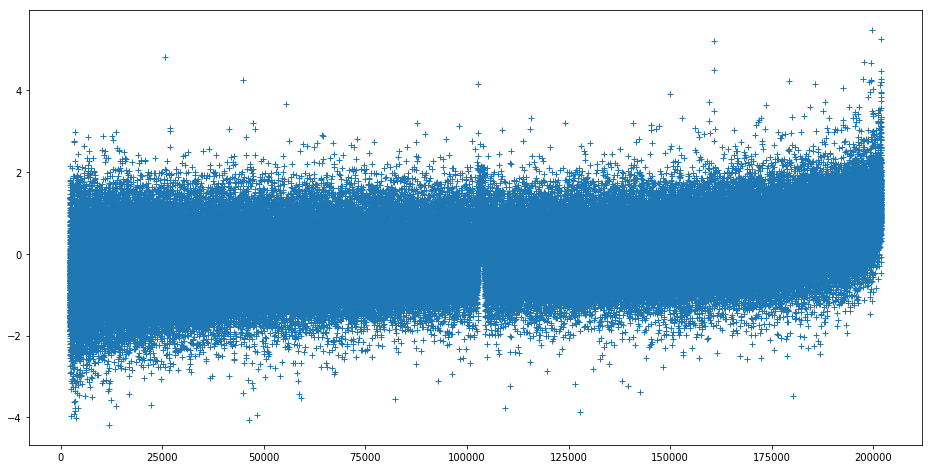

In [157]:
f, ax = plt.subplots(figsize=(16, 8))
plt.plot(t2.sort_values('target').outliers.values, '+', linewidth=0.0001)

In [186]:
train.target.quantile(0.99999)

15.987020054300679

In [202]:
train.target[train.target > 9]

4459      15.606405
4460      17.675716
5205       9.100381
5252      14.855160
5889       9.067359
11921     10.139105
13062      9.823524
15360     11.315665
19090      9.006405
19121      9.629075
20798     10.196864
20858      9.365076
26075     11.759035
26212      9.941370
28609     11.606558
37303     13.310613
39999      9.553418
41325     17.965068
42916      9.183492
44523      9.289373
46687      9.665204
46765     11.030005
46900     10.774194
48103      9.242588
50555      9.516685
51861     11.601576
55191      9.228426
55462     10.241197
58526     10.145651
63378     12.446308
64087      9.886506
67386     10.832827
73436      9.187550
76735      9.558421
78450     11.291580
81037     10.201046
81505     15.171020
81648     11.333782
82971     15.294621
85022     10.358102
85251      9.227683
88341     10.722808
97123      9.488329
98933      9.445932
101409    15.011358
103865    12.970394
105636    11.542822
106793    10.188824
111839     9.407062
115773    12.385323


In [181]:
train.target.describe()

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

In [191]:
len(t1.outlier) * (1 - 0.99999)

1.2362299999943738

In [163]:
pd.DataFrame({"card_id":test.card_id, "target":t1.outlier}).set_index('card_id').to_csv('./data/submission_outliers.csv')

In [227]:
t1 = t1.sort_values('normal')

In [228]:
t1['idx'] = range(len(t1))

In [229]:
t1[t1.idx < 1200]

,card_id,normal,pos,neg,ouliers,idx
77945,C_ID_6ab591cf62,-21.561490,0.798263,-19.977129,-1.835492,0
25568,C_ID_767923bdb9,-20.668267,1.504733,-28.058831,0.383516,1
67890,C_ID_cde027fde7,-20.282833,1.546860,-27.621949,0.748473,2
72221,C_ID_464246c0a5,-20.049266,1.024724,-25.235199,0.162751,3
7750,C_ID_a74b12dcf8,-20.022648,0.949833,-23.357590,-1.342343,4
32446,C_ID_ac114ef831,-19.551338,1.433756,-25.015652,-0.182220,5
104991,C_ID_86ddafb51c,-19.418150,1.288063,-21.982760,-0.999098,6
20556,C_ID_aae50409e7,-19.279287,1.448321,-23.426284,-0.583408,7
100556,C_ID_70c457436a,-18.351773,1.080938,-26.240135,0.197528,8
114106,C_ID_e54aeb08f7,-18.158531,2.296688,-21.406592,-1.002996,9


In [236]:
def ff(data):
    if data.idx < 1200:
        return data.neg
    else:
        return data.normal

In [237]:
ttt = t1.apply(ff, axis=1)

In [240]:
ttt = pd.DataFrame({"card_id":t1.card_id, "target":ttt})

In [241]:
sub = pd.read_csv('./data/sample_submission.csv')

In [244]:
ttt

,card_id,target
77945,C_ID_6ab591cf62,-19.977129
25568,C_ID_767923bdb9,-28.058831
67890,C_ID_cde027fde7,-27.621949
72221,C_ID_464246c0a5,-25.235199
7750,C_ID_a74b12dcf8,-23.357590
32446,C_ID_ac114ef831,-25.015652
104991,C_ID_86ddafb51c,-21.982760
20556,C_ID_aae50409e7,-23.426284
100556,C_ID_70c457436a,-26.240135
114106,C_ID_e54aeb08f7,-21.406592


In [247]:
sub.drop(['target'],axis=1).merge(ttt, how='left').set_index('card_id').to_csv('./data/submission_neg.csv')